In [43]:
import cv2
import numpy as np
import os

# Define the directory containing the images
image_dir = 'C:/Users/HP/Desktop/College/DS203/E7-images'
# List all files in the directory
image_files = os.listdir(image_dir)

# Function to calculate area, perimeter, circularity ratio, equivalent diameter, and shape descriptors
def calculate_shape_features(image, target_color):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold to create a mask of pixels matching the target color
    mask = np.all(image == target_color, axis=2)
    
    # Find contours from the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize area, perimeter, circularity ratio, and equivalent diameter
    area = 0
    perimeter = 0
    circularity_ratio = 0
    equivalent_diameter = 0
    shape_descriptors = []
    
    # Iterate through contours
    for contour in contours:
        # Calculate area and perimeter
        area += cv2.contourArea(contour)
        perimeter += cv2.arcLength(contour, True)
        
        # Calculate circularity ratio
        #circularity_ratio += (4 * np.pi * area) / (perimeter ** 2)
        
        # Calculate equivalent diameter
        equivalent_diameter += np.sqrt(4 * area / np.pi)
        
        # Calculate shape descriptors (Hu moments)
        moments = cv2.moments(contour)
        hu_moments = cv2.HuMoments(moments).flatten()
        shape_descriptors.append(hu_moments)
    
    return int(area), int(perimeter), circularity_ratio, equivalent_diameter, shape_descriptors

In [44]:
# Function to identify bounding boxes or contours and extract dimensions of the tight-fitting box
def extract_tight_fitting_box(image,target_color):
    if image is None:
        print("Error: Unable to load image. Skipping...")
        return 0, 0, 0
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold to create a mask of pixels matching the target color
    mask = np.all(image == target_color, axis=2)
    
    # Find contours
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize lists to store dimensions
    bbox_areas=[]
    layout_area=0
    # Loop over contours
    for contour in contours:
       # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)
        # Calculate the area of the bounding box
        box_area = w * h
        bbox_areas.append(box_area)
        layout_area += box_area
    # Get tight-fitting bounding box parameters
    if bbox_areas:
        max_bbox_area_index = bbox_areas.index(max(bbox_areas))
        x, y, w, h = cv2.boundingRect(contours[max_bbox_area_index])
        bbox_area = bbox_areas[max_bbox_area_index]
    else:
        x, y, w, h = 0, 0, 0, 0
        layout_area = 0

    return w, h, layout_area

In [45]:
# Function to calculate area, perimeter, compactness, elongation, extent, and tight-fitting bounding box using pixel-based method
def calculate_area_perimeter_compactness_bbox_elongation_extent_corners(image, target_color):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold to create a mask of pixels matching the target color
    mask = np.all(image == target_color, axis=2)
    
    # Find contours from the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize area, perimeter, and bounding box parameters
    area = 0
    perimeter = 0
    bbox_areas = []
    
    # Iterate through contours
    for contour in contours:
        area += cv2.contourArea(contour)
        perimeter += cv2.arcLength(contour, True)
        
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)
        bbox_areas.append(w * h)  # Calculate area of bounding box
    
    # Calculate compactness
    compactness = (perimeter ** 2) / area
    
    # Get tight-fitting bounding box parameters
    if bbox_areas:
        max_bbox_area_index = bbox_areas.index(max(bbox_areas))
        x, y, w, h = cv2.boundingRect(contours[max_bbox_area_index])
        bbox_area = bbox_areas[max_bbox_area_index]
    else:
        x, y, w, h = 0, 0, 0, 0
        bbox_area = 0
    
    # Calculate elongation
    if w > h:
        elongation = w / h
    else:
        elongation = h / w
    
    # Calculate extent
    extent = area / bbox_area if bbox_area != 0 else 0
    
    # Detect corners using Shi-Tomasi corner detection
    corners = cv2.goodFeaturesToTrack(gray, 100, 0.02, 5)
    corners_count = corners.shape[0] if corners is not None else 0

    return int(area), int(perimeter), round(compactness, 2), (x, y, w, h), bbox_area, round(elongation, 2), round(extent, 2), corners_count

In [46]:
from sklearn.cluster import KMeans

# Define the directory containing the images
image_dir = 'C:/Users/HP/Desktop/College/DS203/E7-images'
# List all files in the directory
image_files = os.listdir(image_dir)

# Define the number of clusters (adjust as needed)
num_clusters = 4

# Initialize lists to store features
features_list = []

# Loop through each image file
for image_file in image_files:
    # Construct the full path to the image
    image_path = os.path.join(image_dir, image_file)
    images=[]
    # Read the image
    img = cv2.imread(image_path)
    images.append(img)
    # Check if image is loaded properly
    if img is None:
        print(f"Error: Unable to load image {image_file}. Skipping...")
        continue

    # Define the color you want to calculate the area and perimeter for
    target_color = np.array([64, 186, 255])

    # Calculate shape features
    area_count, perimeter_count, circularity_ratio, equivalent_diameter, shape_descriptors = calculate_shape_features(img, target_color)
    
    # Detect corners using Shi-Tomasi corner detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 100, 0.02, 5)
    corners_count = corners.shape[0] if corners is not None else 0
    
    # Append features to the list
    features_list.append([area_count, perimeter_count, circularity_ratio, equivalent_diameter, corners_count])

# Convert the features list to a numpy array
features_array = np.array(features_list)

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(features_array)
cluster_labels = kmeans.labels_

# Print cluster labels for each image
for i, image_file in enumerate(image_files):
    print(f"Image: {image_file}, Cluster: {cluster_labels[i]}")

Image: 0001.jpg, Cluster: 0
Image: 0002.jpg, Cluster: 0
Image: 0003.jpg, Cluster: 1
Image: 0004.jpg, Cluster: 1
Image: 0005.jpg, Cluster: 2
Image: 0006.jpg, Cluster: 0
Image: 0007.jpg, Cluster: 2
Image: 0008.jpg, Cluster: 1
Image: 0009.jpg, Cluster: 1
Image: 0010.jpg, Cluster: 0
Image: 0011.jpg, Cluster: 2
Image: 0012.jpg, Cluster: 0
Image: 0013.jpg, Cluster: 0
Image: 0014.jpg, Cluster: 0
Image: 0015.jpg, Cluster: 3
Image: 0016.jpg, Cluster: 1
Image: 0017.jpg, Cluster: 1
Image: 0018.jpg, Cluster: 2
Image: 0019.jpg, Cluster: 0
Image: 0020.jpg, Cluster: 0
Image: 0021.jpg, Cluster: 1
Image: 0022.jpg, Cluster: 3
Image: 0023.jpg, Cluster: 2
Image: 0024.jpg, Cluster: 1
Image: 0025.jpg, Cluster: 1
Image: 0026.jpg, Cluster: 1
Image: 0027.jpg, Cluster: 3
Image: 0028.jpg, Cluster: 0
Image: 0029.jpg, Cluster: 2
Image: 0030.jpg, Cluster: 2
Image: 0031.jpg, Cluster: 1
Image: 0032.jpg, Cluster: 2
Image: 0033.jpg, Cluster: 2
Image: 0034.jpg, Cluster: 2
Image: 0035.jpg, Cluster: 0
Image: 0036.jpg, Clu

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans

# Define the directory containing the images
image_dir = 'C:/Users/HP/Desktop/College/DS203/E7-images'
# List all files in the directory
image_files = os.listdir(image_dir)

# Split images into train and test sets
X_train, X_test = train_test_split(image_files, test_size=0.2, random_state=42)

# Define the number of clusters (adjust as needed)
num_clusters = 4

# Initialize lists to store features
features_list = []
images=[]

# Initialize lists to store values
elongation_values = []
extent_values = []
compactness_values = []
corners_count_values = []

# Loop through each image file
for image_file in X_train:
    # Construct the full path to the image
    image_path = os.path.join(image_dir, image_file)
    # Read the image
    img = cv2.imread(image_path)
    images.append(img)
    # Check if image is loaded properly
    if img is None:
        print(f"Error: Unable to load image {image_file}. Skipping...")
        continue

    # Define the color you want to calculate the area and perimeter for
    target_color = np.array([64, 186, 255])

    # Calculate shape features
    area_count, perimeter_count, circularity_ratio, equivalent_diameter, shape_descriptors = calculate_shape_features(img, target_color)
    
    # Detect corners using Shi-Tomasi corner detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 100, 0.02, 5)
    corners_count = corners.shape[0] if corners is not None else 0
    
    # Append features to the list
    features_list.append([area_count, perimeter_count, circularity_ratio, equivalent_diameter, corners_count])

    # Calculate area, perimeter, compactness, bounding box, elongation, extent, and corners count
    area_count_2, perimeter_count_2, compactness_2, bbox_params_2, bbox_area_2, elongation_2, extent_2, corners_count_2 = calculate_area_perimeter_compactness_bbox_elongation_extent_corners(img, target_color)

    # Append values to the lists
    elongation_values.append(elongation_2)
    extent_values.append(extent_2)
    compactness_values.append(compactness_2)
    corners_count_values.append(corners_count_2)
    
# Convert the features list to a numpy array
features_array = np.array(features_list)

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(features_array)
cluster_labels = kmeans.labels_

# Print cluster labels for each image
for i, image_file in enumerate(X_train):
    print(f"Image: {image_file}, Cluster: {cluster_labels[i]}")

Image: 0651.jpg, Cluster: 1
Image: 0978.jpg, Cluster: 2
Image: 0994.jpg, Cluster: 1
Image: 0731.jpg, Cluster: 0
Image: 0276.jpg, Cluster: 1
Image: 0364.jpg, Cluster: 1
Image: 0044.jpg, Cluster: 1
Image: 0542.jpg, Cluster: 2
Image: 0725.jpg, Cluster: 0
Image: 0799.jpg, Cluster: 2
Image: 0136.jpg, Cluster: 2
Image: 1054.jpg, Cluster: 0
Image: 0079.jpg, Cluster: 2
Image: 0606.jpg, Cluster: 2
Image: 0185.jpg, Cluster: 1
Image: 0655.jpg, Cluster: 1
Image: 0179.jpg, Cluster: 1
Image: 1179.jpg, Cluster: 1
Image: 0248.jpg, Cluster: 1
Image: 0849.jpg, Cluster: 0
Image: 1113.jpg, Cluster: 3
Image: 0763.jpg, Cluster: 2
Image: 0368.jpg, Cluster: 1
Image: 0433.jpg, Cluster: 1
Image: 0579.jpg, Cluster: 3
Image: 1075.jpg, Cluster: 2
Image: 0622.jpg, Cluster: 2
Image: 0821.jpg, Cluster: 0
Image: 0866.jpg, Cluster: 2
Image: 0040.jpg, Cluster: 1
Image: 0031.jpg, Cluster: 1
Image: 0243.jpg, Cluster: 1
Image: 0546.jpg, Cluster: 0
Image: 0137.jpg, Cluster: 1
Image: 0983.jpg, Cluster: 1
Image: 0573.jpg, Clu

In [48]:
elongation = np.array(elongation_values)
extent = np.array(extent_values)
compactness = np.array(compactness_values)
corners_count = np.array(corners_count_values)

complexity = elongation*corners_count*compactness/extent

arr_below_33 = complexity[complexity <= 1350]
indices_below_33 = np.where(complexity <= 1350)[0]

arr_between_33_and_66 = complexity[(complexity > 1350) & (complexity < 3374)]
indices_between_33_66 = np.where((complexity > 1350) & (complexity < 3374))[0]

arr_above_66 = complexity[complexity >= 3374]
indices_above_66 = np.where(complexity >= 3374)[0]

for i in range(len(complexity)):
    if(complexity[i] < 1350):
        complexity[i]= 0
    elif(complexity[i] > 3374):
        complexity[i]= 2
    else:
        complexity[i]= 1

In [49]:
# Extract tight box parameters for training set
X_train_tight_box_dimensions = []
X_train_tight_box_areas = []
X_train_complexity = complexity
y_train = cluster_labels

for image in images:
    width, height, area = extract_tight_fitting_box(image,target_color)
    X_train_tight_box_dimensions.append([width, height])
    X_train_tight_box_areas.append(area)

# Convert lists to numpy arrays
X_train_tight_box_dimensions = np.array(X_train_tight_box_dimensions)
X_train_tight_box_areas = np.array(X_train_tight_box_areas)
X_train_complexity = np.array(X_train_complexity)

# Combine synthetic parameters with cluster labels and encoded complexity
X_all_features_train = np.hstack((X_train_tight_box_dimensions, X_train_tight_box_areas.reshape(-1, 1), X_train_complexity.reshape(-1, 1)))

# Train a machine learning model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_all_features_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
from sklearn.svm import SVC
# Train a machine learning model with SVC using RBF kernel
svc_classifier = SVC(kernel='rbf', random_state=42)
svc_classifier.fit(X_all_features_train, y_train)

SVC(random_state=42)

In [51]:
# Initialize lists to store features
features_list = []
images=[]

# Initialize lists to store values
elongation_values = []
extent_values = []
compactness_values = []
corners_count_values = []

# Loop through each image file
for image_file in X_test:
    # Construct the full path to the image
    image_path = os.path.join(image_dir, image_file)
    # Read the image
    img = cv2.imread(image_path)
    images.append(img)
    # Check if image is loaded properly
    if img is None:
        print(f"Error: Unable to load image {image_file}. Skipping...")
        continue

    # Define the color you want to calculate the area and perimeter for
    target_color = np.array([64, 186, 255])

    # Calculate shape features
    area_count, perimeter_count, circularity_ratio, equivalent_diameter, shape_descriptors = calculate_shape_features(img, target_color)
    
    # Detect corners using Shi-Tomasi corner detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 100, 0.02, 5)
    corners_count = corners.shape[0] if corners is not None else 0
    
    # Append features to the list
    features_list.append([area_count, perimeter_count, circularity_ratio, equivalent_diameter, corners_count])

    # Calculate area, perimeter, compactness, bounding box, elongation, extent, and corners count
    area_count_2, perimeter_count_2, compactness_2, bbox_params_2, bbox_area_2, elongation_2, extent_2, corners_count_2 = calculate_area_perimeter_compactness_bbox_elongation_extent_corners(img, target_color)

    # Append values to the lists
    elongation_values.append(elongation_2)
    extent_values.append(extent_2)
    compactness_values.append(compactness_2)
    corners_count_values.append(corners_count_2)
# Convert the features list to a numpy array
features_array = np.array(features_list)

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(features_array)
cluster_labels_test = kmeans.labels_

# Print cluster labels for each image
for i, image_file in enumerate(X_test):
    print(f"Image: {image_file}, Cluster: {cluster_labels_test[i]}")

Image: 0804.jpg, Cluster: 3
Image: 1136.jpg, Cluster: 1
Image: 1049.jpg, Cluster: 3
Image: 0087.jpg, Cluster: 3
Image: 0935.jpg, Cluster: 3
Image: 0480.jpg, Cluster: 1
Image: 1138.jpg, Cluster: 2
Image: 0972.jpg, Cluster: 1
Image: 0494.jpg, Cluster: 1
Image: 0345.jpg, Cluster: 0
Image: 0221.jpg, Cluster: 2
Image: 0925.jpg, Cluster: 1
Image: 1003.jpg, Cluster: 0
Image: 0713.jpg, Cluster: 1
Image: 0244.jpg, Cluster: 0
Image: 0171.jpg, Cluster: 1
Image: 0275.jpg, Cluster: 0
Image: 0412.jpg, Cluster: 1
Image: 0858.jpg, Cluster: 1
Image: 1169.jpg, Cluster: 0
Image: 1122.jpg, Cluster: 2
Image: 0266.jpg, Cluster: 2
Image: 0733.jpg, Cluster: 2
Image: 0200.jpg, Cluster: 0
Image: 0734.jpg, Cluster: 2
Image: 1117.jpg, Cluster: 3
Image: 0840.jpg, Cluster: 0
Image: 0414.jpg, Cluster: 0
Image: 0169.jpg, Cluster: 3
Image: 1170.jpg, Cluster: 3
Image: 0597.jpg, Cluster: 1
Image: 0059.jpg, Cluster: 0
Image: 0778.jpg, Cluster: 0
Image: 1176.jpg, Cluster: 1
Image: 0586.jpg, Cluster: 1
Image: 0024.jpg, Clu

In [52]:
elongation = np.array(elongation_values)
extent = np.array(extent_values)
compactness = np.array(compactness_values)
corners_count = np.array(corners_count_values)

complexity2 = elongation*corners_count*compactness/extent

arr_below_33 = complexity2[complexity2 <= 1350]
indices_below_33 = np.where(complexity2 <= 1350)[0]

arr_between_33_and_66 = complexity2[(complexity2 > 1350) & (complexity2 < 3374)]
indices_between_33_66 = np.where((complexity2 > 1350) & (complexity2 < 3374))[0]

arr_above_66 = complexity2[complexity2 >= 3374]
indices_above_66 = np.where(complexity2 >= 3374)[0]

for i in range(len(complexity2)):
    if(complexity2[i] < 1350):
        complexity2[i]= 0
    elif(complexity2[i] > 3374):
        complexity2[i]= 2
    else:
        complexity2[i]= 1

In [53]:
# Extract tight box parameters for test set
X_test_tight_box_dimensions = []
X_test_tight_box_areas = []
X_test_complexity = complexity2

for image in images:
    width, height, area = extract_tight_fitting_box(image,target_color)
    X_test_tight_box_dimensions.append([width, height])
    X_test_tight_box_areas.append(area)

# Convert lists to numpy arrays
X_test_tight_box_dimensions = np.array(X_test_tight_box_dimensions)
X_test_tight_box_areas = np.array(X_test_tight_box_areas)
X_test_complexity = np.array(X_test_complexity)

X_test_tight_box_dimensions = np.array(X_test_tight_box_dimensions)
X_test_tight_box_areas = np.array(X_test_tight_box_areas)
X_test_complexity = np.array(X_test_complexity)

y_test = cluster_labels_test

# Combine synthetic parameters with cluster labels and encoded complexity
X_all_features_test = np.hstack((X_test_tight_box_dimensions, X_test_tight_box_areas.reshape(-1, 1), X_test_complexity.reshape(-1, 1)))

# Predict cluster labels for test data
y_pred = rf_classifier.predict(X_all_features_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8438818565400844


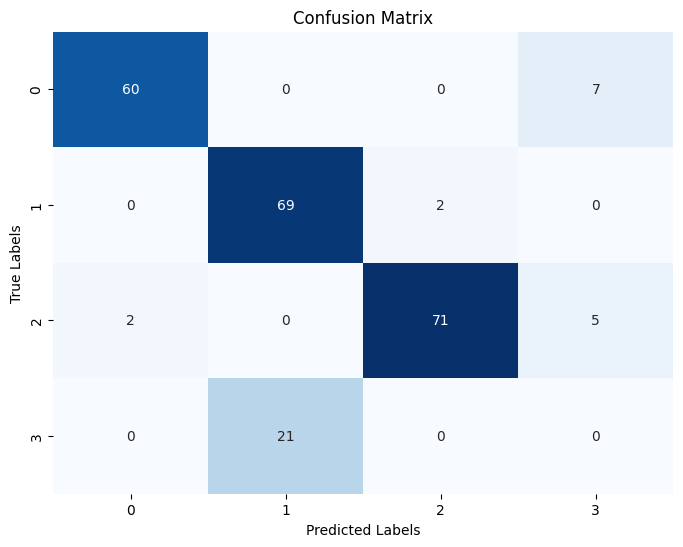

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Predict cluster labels for test data
y_pred = svc_classifier.predict(X_all_features_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.31223628691983124


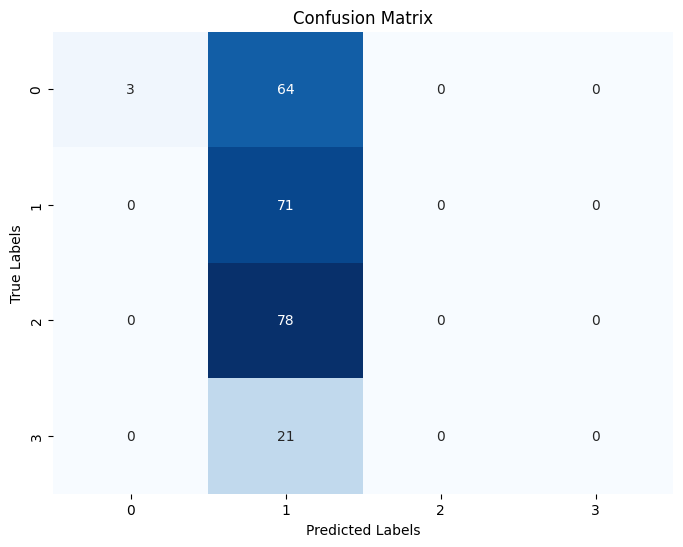

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()